## Просьба пока не смотреть - дорабатываю

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:21, 2470.74it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [5]:
# проверим сколько всего отзывов

In [6]:
len(responses)

153499

In [7]:
# посмотрим сколько всего городов и отзывов в городах

In [8]:
cities = {}
for i in range(len(responses)):
    if responses[i]['city'] in cities:
        cities[responses[i]['city']]+=1
    else:
        cities.setdefault(responses[i]['city'], 1)        

In [9]:
# Посмотрим города с самым большим количеством отзывов

In [10]:
cities_sorted = sorted(cities.items(), key=lambda cities: cities[1], reverse=True)

In [11]:
len(cities_sorted)

5824

In [12]:
cities_sorted[:10] 

[('г. Москва', 55354),
 (None, 15174),
 ('г. Санкт-Петербург', 14342),
 ('г. Екатеринбург', 2337),
 ('г. Новосибирск', 2300),
 ('г. Нижний Новгород', 1976),
 ('г. Ростов-на-Дону', 1891),
 ('г. Самара', 1731),
 ('г. Челябинск', 1507),
 ('г. Казань', 1440)]

In [13]:
banks = {}
for i in range(len(responses)):
    if responses[i]['bank_name'] in banks:
        banks[responses[i]['bank_name']]+=1
    else:
        banks.setdefault(responses[i]['bank_name'], 1) 

In [14]:
banks_sorted = sorted(banks.items(), key=lambda banks: banks[1], reverse=True)

In [15]:
len(banks_sorted)

670

In [16]:
banks_sorted[:10]

[('Сбербанк России', 26327),
 ('Альфа-Банк', 10224),
 ('ВТБ 24', 8185),
 ('Русский Стандарт', 7943),
 ('Хоум Кредит Банк', 7549),
 ('Тинькофф Банк', 5387),
 ('Национальный Банк «Траст»', 4607),
 ('Ренессанс Кредит', 3849),
 ('Связной Банк', 3775),
 ('ОТП Банк', 3237)]

In [17]:
texts = []
for i in range(len(responses)):
    texts.append(responses[i]['text'])

In [35]:
len_texts = []
len_chars = []
for i in texts:
    len_texts.append(len(i.split(' ')))
    len_chars.append(len(i))

In [36]:
# построим гистограмму по количеству слов в текстах

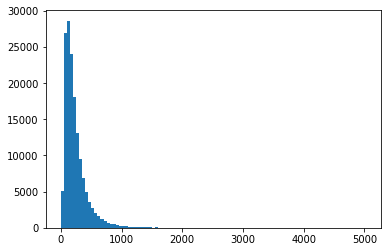

In [37]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(len_texts, bins  = 100)
fig.show()

In [36]:
# построим гистограмму по количеству символов в текстах

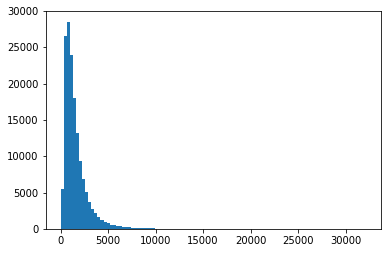

In [39]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(len_chars, bins  = 100)
fig.show()

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


NameError: name 'CountVectorizer' is not defined